## Gaussian Copula Resmapling

In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import projplot.proj_plot as pjp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import particle_resamplers as resampler
from pfjax import models
import optax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims = np.array(list(zip(theta - (theta/2), theta + (theta/2))))

dt = 0.1
n_res = 1
n_obs = 100

key = random.PRNGKey(0)
key, subkey = random.split(key)

In [3]:
lotvol_model = models.LotVolModel(dt, n_res) 

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas, x_state = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta, 
                              key = subkey)
y_meas_abs = jnp.abs(y_meas)

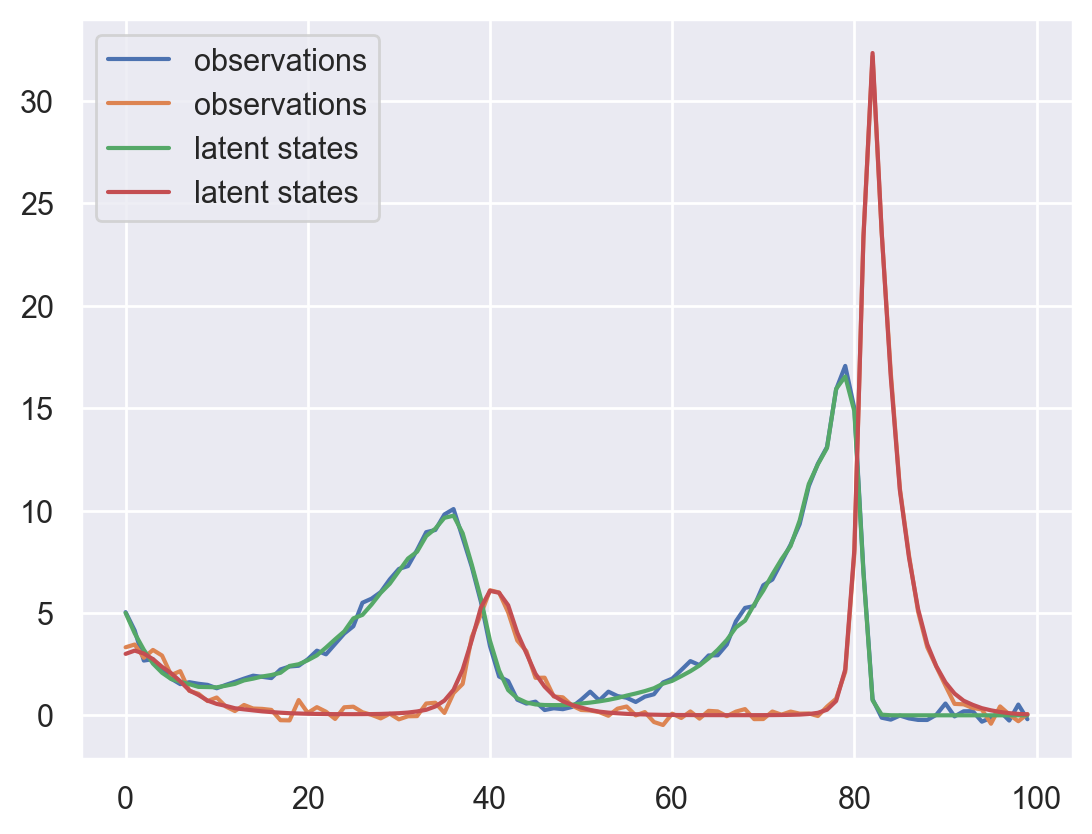

In [4]:
plt.plot(y_meas, label = "observations");
plt.plot(jnp.exp(x_state.squeeze()), label = "latent states")
plt.legend();

In [5]:
theta_lims = jnp.array([
    [0.8, 1.2],
    [0.9, 1.1],
    [3.8, 4.2],
    [0.95, 1.05],
    [0.05, 0.2],
    [0.01, 0.2],
    [0.1, 0.4],
    [0.1, 0.4]])

#### Custom Resampler

In [40]:
from pfjax.utils import lwgt_to_prob, weighted_corr, argsort_marginal, continuous_cdf, interpolate_weights

def sort_marginal (x, weights):
    r""" 
    Sort X and return corresponding w
    """
    sorted_x, sorted_w = jax.lax.sort_key_val(x, weights)
    return {"x": sorted_x, "w": sorted_w}

def marginal_cdf (x, data, weights):
    r"""
    Return quantile of x given data and weights
    """
    return sum(jnp.where(data <= x, x = weights, y=0))

def custom_gc(key, x_particles_prev, logw):
    p_shape = x_particles_prev.shape
    N = p_shape[0]
    x_particles = x_particles_prev.reshape((N, -1))
    d = x_particles.shape[-1]
    prob = lwgt_to_prob(logw)

    # estimate correlation matrix: 
    Y = jax.vmap(
        lambda x: 
        jax.vmap(
            marginal_cdf,
            in_axes = (0, None, None)
        )(x, x, prob),
        in_axes = (1))(x_particles)
    rho_hat = weighted_corr(Y, weights = prob)

    # gaussian copula: 
    Z = random.multivariate_normal(key=key, mean = jnp.zeros(d), cov = rho_hat, shape = (N,))
    U = jax.scipy.stats.norm.cdf(Z)

    sorted_marginals = jax.vmap(
        sort_marginal,
        in_axes = (1, None)
    )(x_particles, prob)

    x_samples = jax.vmap(
        lambda x, w, u: jax.vmap(
            continuous_cdf,
            in_axes= (None, None, 0)
        )(x, w, u),
        in_axes = (0, 0, 1))(sorted_marginals["x"], sorted_marginals["w"], U)

    return {
        "x_particles": jnp.reshape(jnp.transpose(x_samples), newshape=p_shape)
    }

In [ ]:
def resample_gaussian_copula(key, x_particles_prev, logw):
    r"""
    Particle resampler with Gaussian Copula distribution.

    Estimate and sample from a Gaussian copula as follows: 
        - Find Y = (F_1(X_1), ..., F_d(X_d))
        - rho_hat = weighted correlation of Y 
        - Sample Z ~ N(0, rho_hat) N times
        - Create U = (phi(Z_1), ..., phi(Z_d))
        - Use inverse-CDF of marginals to create samples: (inv-CDF(U_1), ..., inv-CDF(U_d))

    Args: 
        key: PRNG key
        x_particles_prev: An `ndarray` with leading dimension `n_particles` consisting of the particles from the previous time step.
        logw: Vector of corresponding `n_particles` unnormalized log-weights.

    Returns: 
        A dictionary with elements:
            - `x_particles`: An `ndarray` with leading dimension `n_particles` consisting of the particles from the current time step.  These are sampled with replacement from `x_particles_prev` with probability vector `exp(logw) / sum(exp(logw))`.
            - `ancestors`: Vector of `n_particles` integers between 0 and `n_particles-1` giving the index of each element of `x_particles_prev` corresponding to the elements of `x_particles`.

    TODO: 
        - Should be able to use jnp.take() with the `continuous_cdf` block and remove a vmap
    """
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    x_particles = x_particles_prev.reshape((n_particles, -1))
    d = x_particles.shape[-1]
    prob = lwgt_to_prob(logw)
    
    # sort marginals: 
    sorted_marginals = jax.vmap(
        argsort_marginal,
        in_axes = (1, None)
    )(x_particles, prob)

    # estimate correlation matrix: 
    Y = jax.vmap(
        lambda unsorted_x, sorted_x, sorted_index: jax.vmap(
            lambda x, w: w[jnp.argmax(sorted_x == x)],
            in_axes = (0, None)
        )(unsorted_x, jnp.cumsum(prob[sorted_index])),
        in_axes = (1, 0, 0,)
    )(x_particles, sorted_marginals["x"], sorted_marginals["indices"])

    rho_hat = weighted_corr(Y, weights = prob)

    # gaussian copula: 
    Z = random.multivariate_normal(key=key, mean = jnp.zeros(d), cov = rho_hat, shape = (n_particles,))
    U = jax.scipy.stats.norm.cdf(Z)

    interpolated_weights = jax.vmap(interpolate_weights, in_axes = (0,))(sorted_marginals["w"])

    x_samples = jax.vmap(
        lambda x, w, u: jax.vmap(
            continuous_cdf,
            in_axes= (None, None, 0)
        )(x, w, u),
        in_axes = (0, 0, 1))(sorted_marginals["x"], interpolated_weights, U)

    return {
        "x_particles": jnp.reshape(jnp.transpose(x_samples), newshape=p_shape)
    }

In [13]:
@partial(jax.jit, static_argnums=(1,2))
def lotvol_neg_loglik(theta, resampler = resampler.resample_mvn, n_particles=100):
    """
    Negative log-likelihood for lotka volterra model (lotvol_model)
    """
    temp = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler)
    return -temp["loglik"]


@partial(jax.jit, static_argnums=(1,))
def particle_neg_loglik_mvn(theta, n_particles=100):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(1,))
def particle_neg_loglik_gc(theta, n_particles=500):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(1,))
def particle_neg_loglik_gc2(theta, n_particles=500):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = custom_gc)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(1,))
def particle_neg_loglik_bootstrap(theta, n_particles=500):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=lotvol_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [14]:
gc_ll = particle_neg_loglik_gc(theta)
print("GC: ", gc_ll)

# gc2_ll = particle_neg_loglik_gc2(theta)
# print("GC 2: ", gc2_ll)

mvn_ll = particle_neg_loglik_mvn(theta)
print("MVN: ", mvn_ll)

bootstrap_ll = particle_neg_loglik_bootstrap(theta)
print("Bootstrap: ", bootstrap_ll)

GC:  51.360522217790844
MVN:  55.6935443848929
Bootstrap:  54.88170669523765


In [15]:
# calculate projection plot for exact loglikelihood
df_gc = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_gc(x), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

# # calculate projection plot for exact loglikelihood
# df_custom_gc = pjp.proj_plot(
#     fun = lambda x: particle_neg_loglik_gc2(x), 
#     x_opt=theta, 
#     x_lims=theta_lims, 
#     x_names=theta_names, 
#     n_pts=100,
#     plot=False
# )

# calculate projection plot for exact loglikelihood
df_mvn = pjp.proj_plot(
    fun = lambda x: particle_neg_loglik_mvn(x), 
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

# calculate projection plot for particle filter loglikelihood
df_multinom = pjp.proj_plot(
    fun=lambda x: particle_neg_loglik_bootstrap(x),
    x_opt=theta, 
    x_lims=theta_lims, 
    x_names=theta_names, 
    n_pts=100,
    plot=False
)

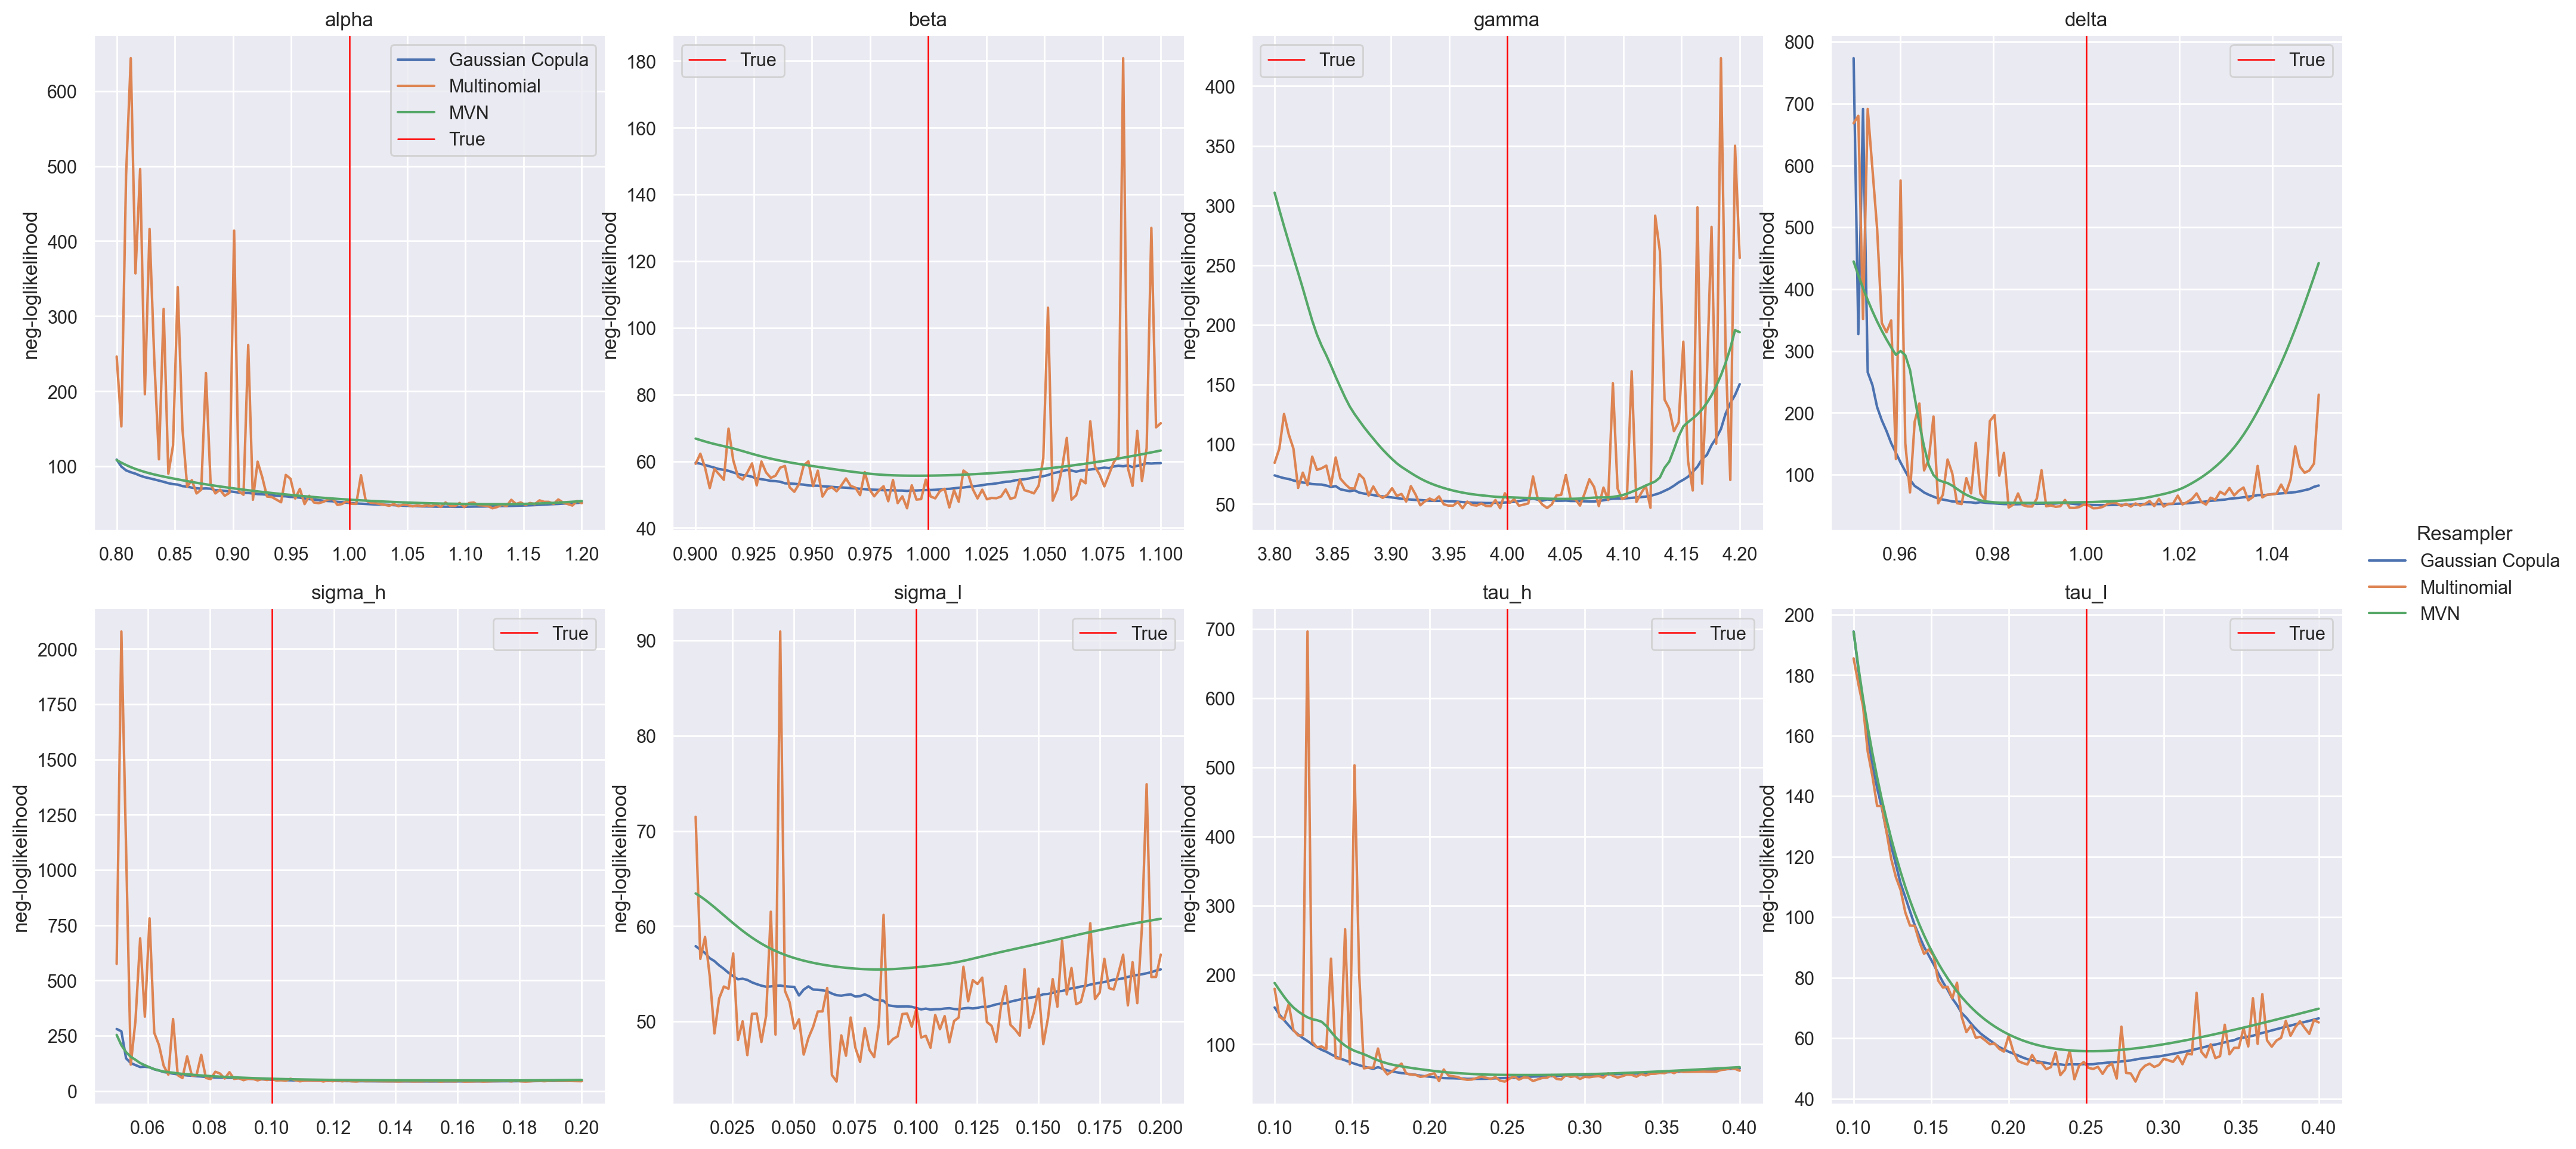

In [16]:
# merge data frames and plot them
plot_df = pd.concat([df_gc, df_multinom, df_mvn], ignore_index=True)
plot_df["Resampler"] = np.repeat(["Gaussian Copula", "Multinomial", "MVN"], len(df_gc["x_opt"]))
plot_df = plot_df.rename(columns={"y": "neg-loglikelihood"})

grid = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None)

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.9, label="True")
    _ax.legend();

# Stochastic Optimization 

TODO: 

- Use bridge proposal 
- Work precision plots:
    - Benchmark: Take true params and 5k particles (lots of particles)
    - Run basic pf with a diff number of particles with diff seeds each time
    - Evaluate the log-lik on each of these particles 100 times each (multiple times each)
    - Record the runtime per random seed, for each of the number of particles
    - Calculate RMSE for each of the true params and estimated params for each # of particles
    - Plot (clock time VS accuracy) for each method. Doesn't have to be the same number of particle for each method, 

In [17]:
@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_mvn(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_gc(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(3, 4, ))
def particle_neg_loglik_bootstrap(theta, key, y_meas, n_particles=500, model=lotvol_model):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [18]:
%%timeit
bootstrap_ll = particle_neg_loglik_bootstrap(theta, key, y_meas)

17.1 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
mvn_ll = particle_neg_loglik_mvn(theta, key, y_meas)

20.3 ms ± 670 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
gc_ll = particle_neg_loglik_gc(theta, key, y_meas)

267 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
import time

def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, 
                  y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    loglik_value, params_update = jax.value_and_grad(grad_fun, argnums=0)(
        params, key=subkey, n_particles=n_particles, y_meas=y_meas, model=model)
    params_update = jnp.where(mask, params_update, 0)
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates), loglik_value


def simple_grad_descent (model, theta, grad_fun, y_meas, n_particles=100, 
                         n_iter=10, learning_rate=0.01, key=1, mask=None):
    """ Deterministic optimization """
    optimizer = optax.adam(learning_rate) 
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, 
                                    grad_fun=grad_fun, optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    losses = []
    thetas = []
    times = []
    for i in range(n_iter):
        # get value of loss function to make sure we are minimizing 
        start_time = time.perf_counter()
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        times.append(time.perf_counter() - start_time)
        losses.append(loglik_value)
        thetas.append(theta)
    return theta, losses, thetas, times


def stoch_opt(model, theta, grad_fun, y_meas, n_particles=100, 
              n_iter=10, learning_rate=0.01, key=1, mask=None):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(theta)
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    keys = random.split(key, n_iter)
    losses = []
    thetas = []
    for subkey in keys:
        theta, loglik_value = update_fn(theta, subkey, opt_state)
        losses.append(loglik_value)
        thetas.append(theta)
    return theta, losses, thetas

In [28]:
init_params = jnp.array([1.1 , .9  , 3.8  , 1.2  , 0.1 , 0.1 , 0.25, 0.25]) # true params
# init_params = theta
print("True params:    ", theta)
print("Initial params: ", init_params)

True params:     [1.   1.   4.   1.   0.1  0.1  0.25 0.25]
Initial params:  [1.1  0.9  3.8  1.2  0.1  0.1  0.25 0.25]


In [29]:
# Fix parameters and run both filters with these: 
n_particles = 500
n_iter = 500
learning_rate = 1e-2

start = time.time()
mvn_params, mvn_losses, mvn_steps, mvn_times = simple_grad_descent(
    key = key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_mvn,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params))
)

print("Time: ", time.time() - start)
print("Estimated params: ", mvn_params)

Time:  21.122027158737183
Estimated params:  [nan nan nan nan nan nan nan nan]


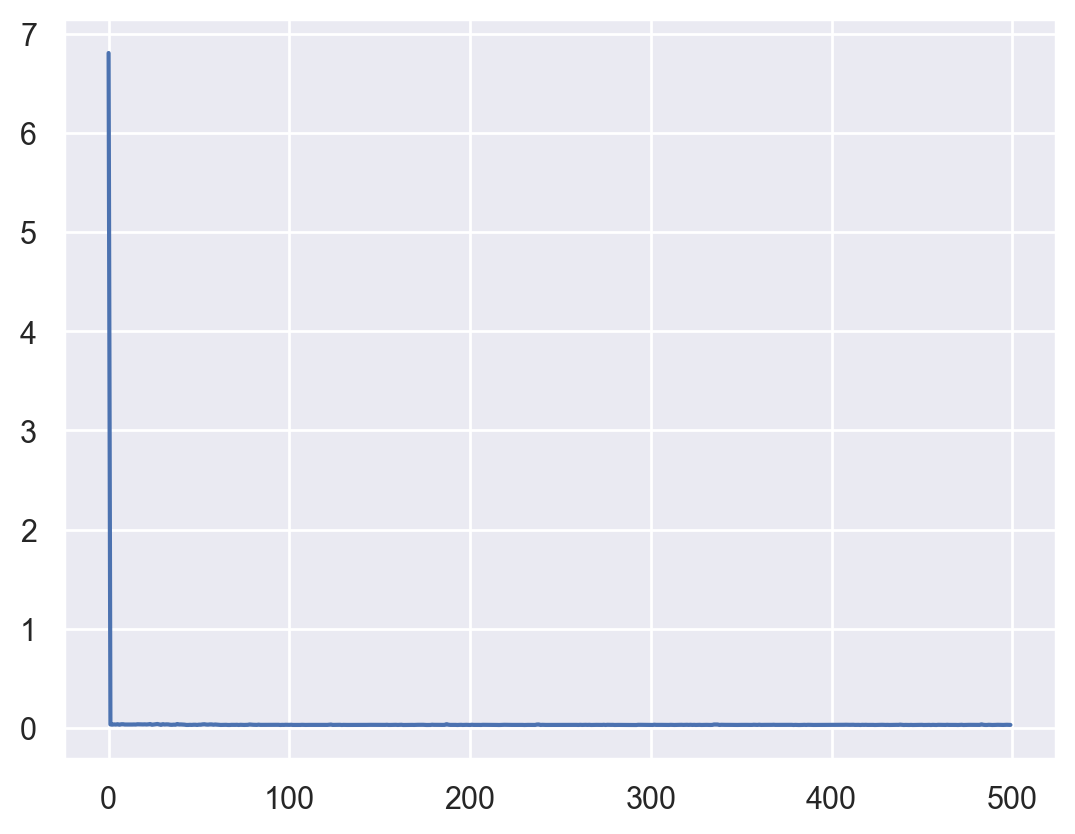

In [30]:
plt.plot(np.arange(len(mvn_times)), mvn_times);

In [31]:
# Fix parameters and run both filters with these: 
n_particles = 500
n_iter = 500
learning_rate = 1e-2

start = time.time()
gc_params, gc_losses, gc_steps, gc_times = simple_grad_descent(
    key = key,
    model = lotvol_model,
    grad_fun = particle_neg_loglik_gc,
    y_meas = y_meas,
    theta = init_params,
    learning_rate = learning_rate,
    n_iter = n_iter,
    n_particles = n_particles,
    mask=np.ones(len(init_params))
)

print("Time: ", time.time() - start)
print("Estimated params: ", gc_params)

Time:  437.35772800445557
Estimated params:  [nan nan nan nan nan nan nan nan]


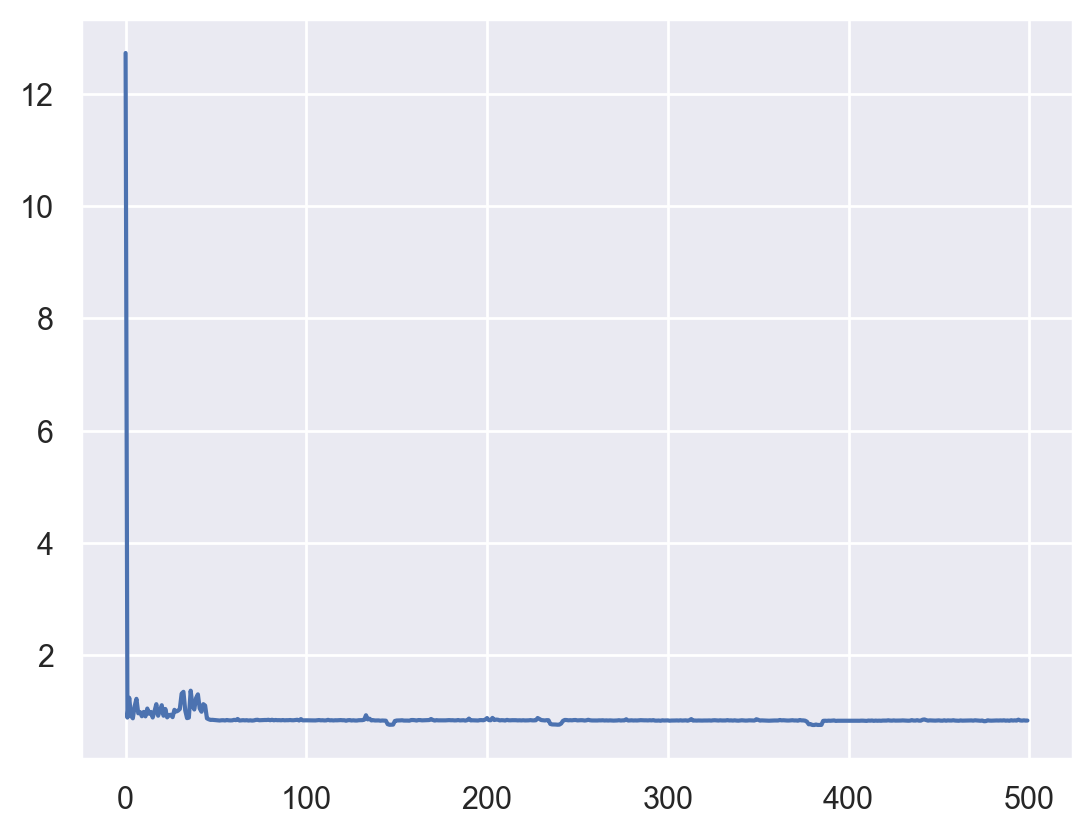

In [32]:
plt.plot(np.arange(len(gc_times)), gc_times);

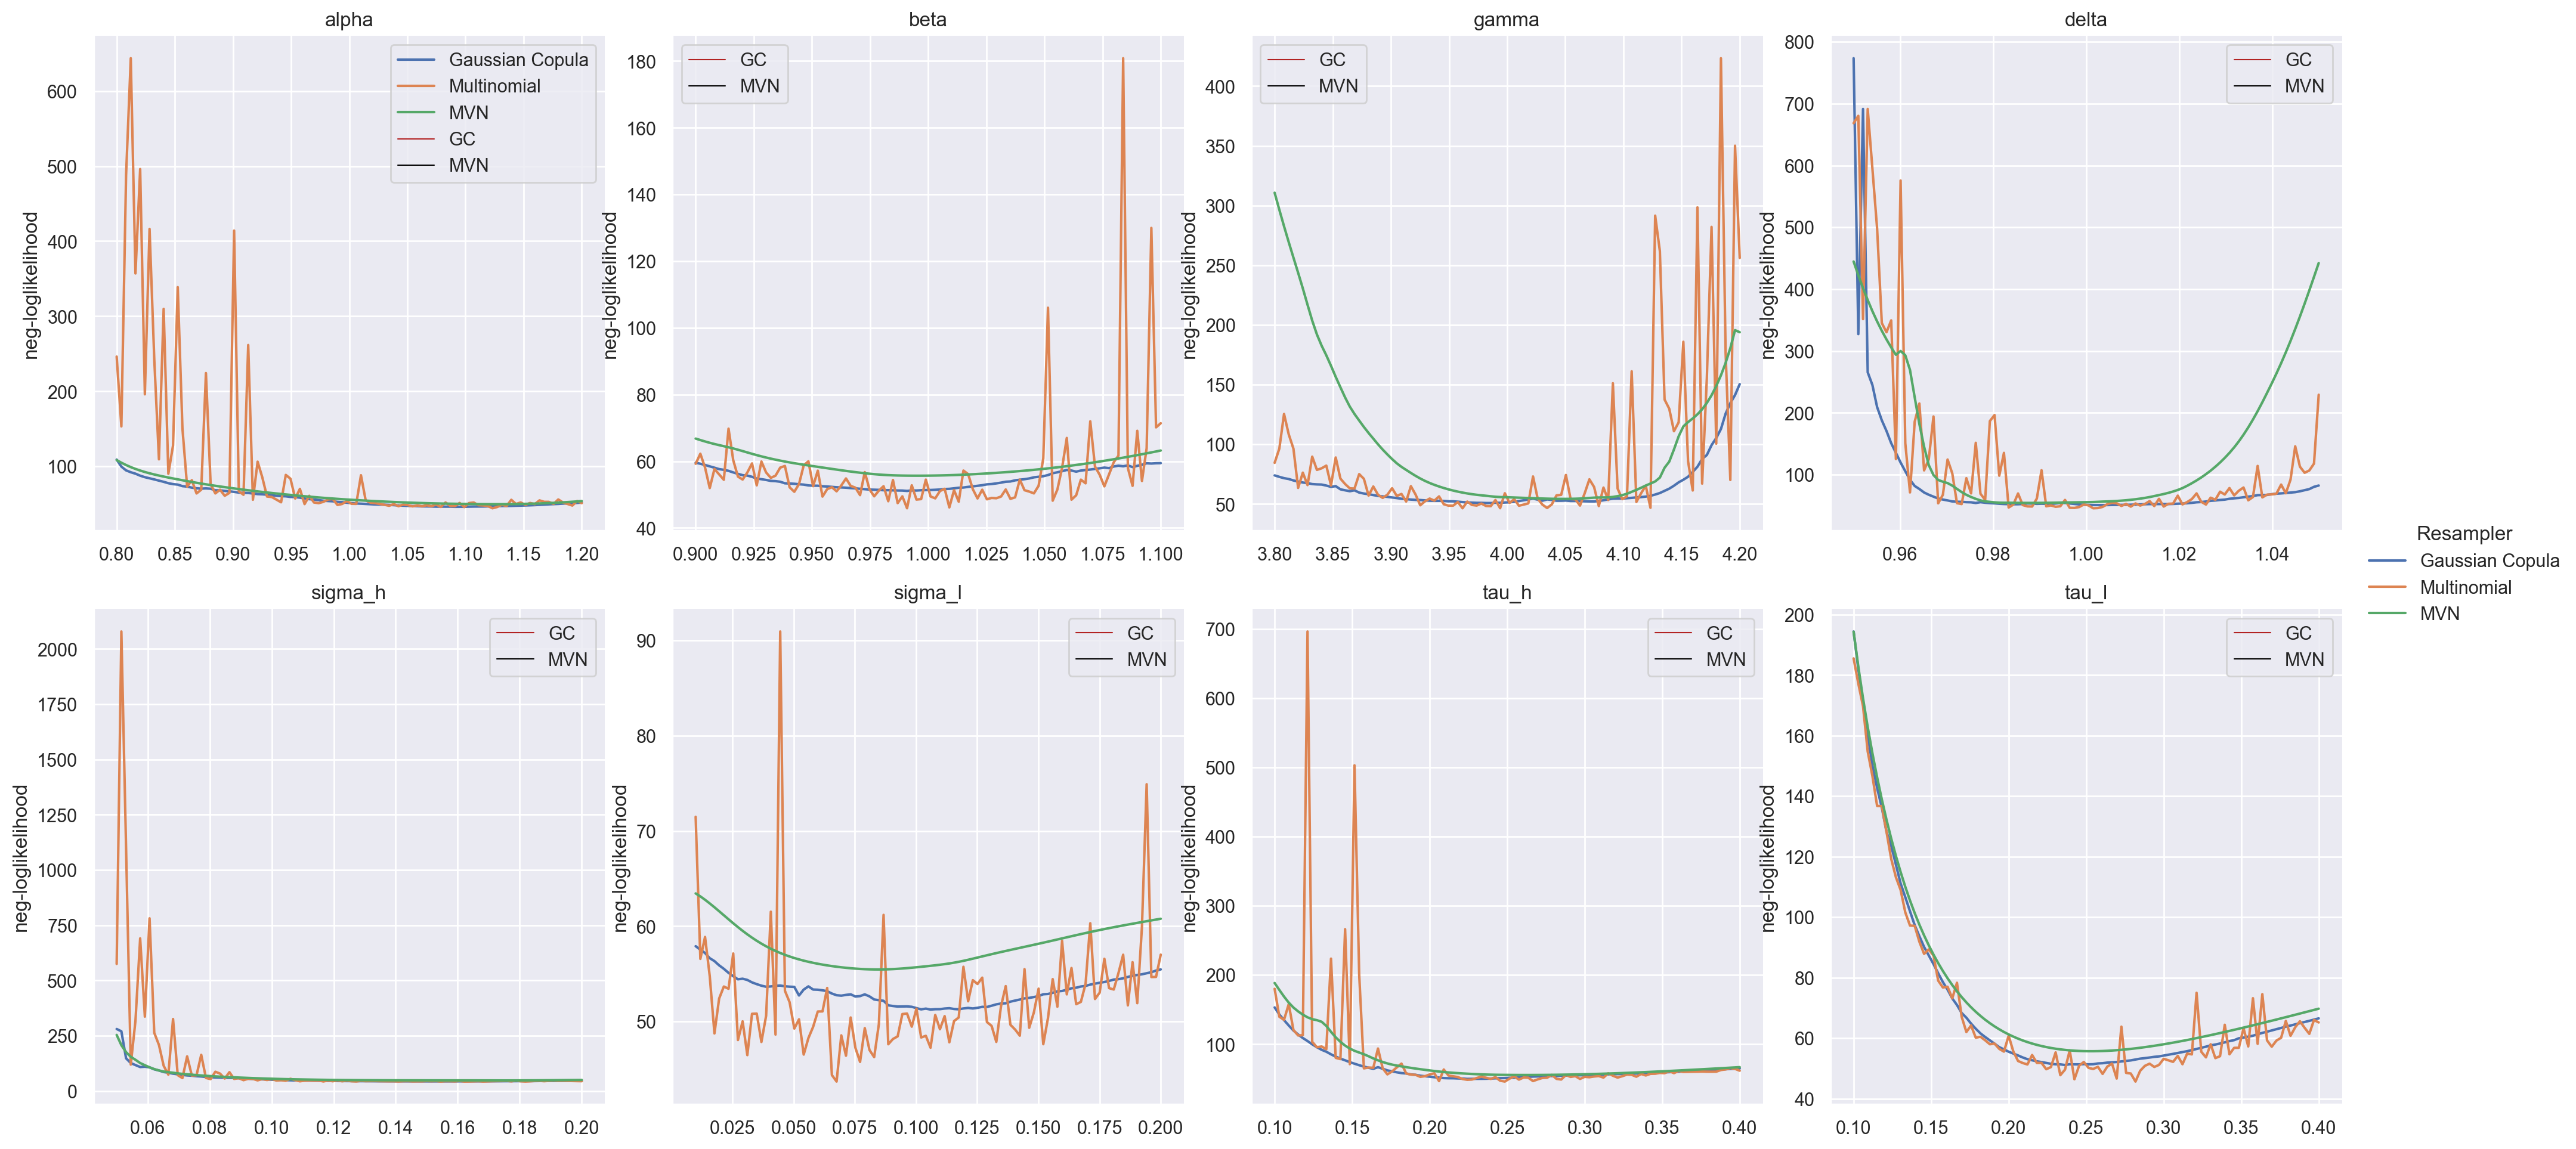

In [33]:
grid = sns.relplot(
    data=plot_df,
    kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None)

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(gc_params[ind], color='firebrick', lw = 0.75, label="GC")
    _ax.axvline(mvn_params[ind], color='black', lw = 0.75, label="MVN")
    _ax.legend();

## Experiments

- Record time for each step of the stochastic optimization

### From Tutorial

In [26]:
from pfjax.models import BMModel

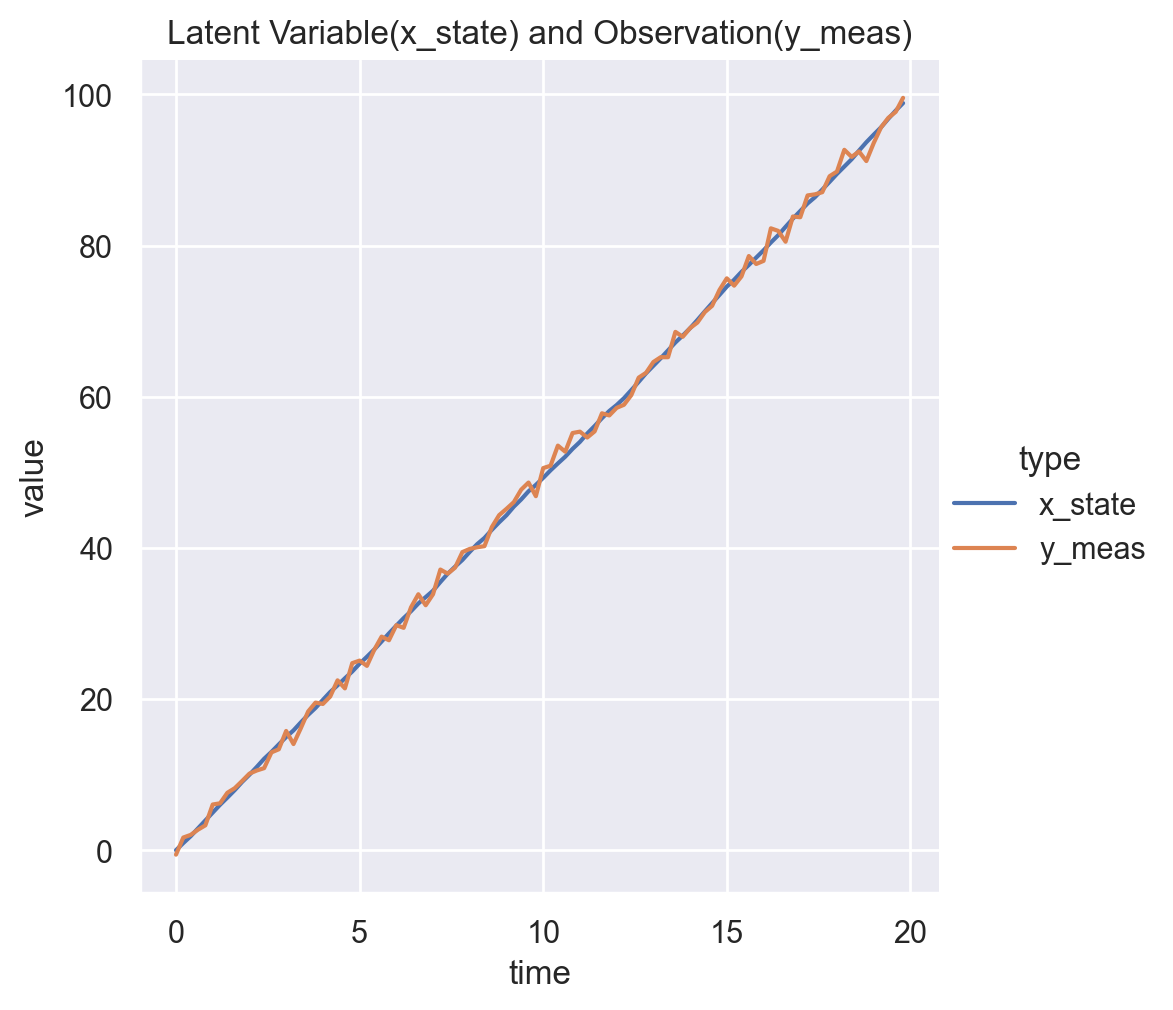

In [28]:
# initial key for random numbers
key = random.PRNGKey(0)
sns.set_style("darkgrid")
# parameter values
mu = 5.
sigma = .2
tau = 1.
theta = np.array([mu, sigma, tau])

# data specification
dt = .2
n_obs = 100
x_init = jnp.array([0.])

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, key, n_obs, x_init, theta)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)
plt.title("Latent Variable(x_state) and Observation(y_meas)");

In [29]:
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for projxvals and projdata.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)

theta_lims = np.array([[3., 8.], [0., .4], [.5, 2]])
theta_names = ["mu", "sigma", "tau"]
n_pts = 100

@jax.jit
def bm_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=bm_model, y_meas=y_meas,
                              n_particles=100, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(bm_pflik, theta, theta_lims, theta_names);

AttributeError: module 'projplot.proj_plot' has no attribute 'projxvals'

In [32]:
import optax
from functools import partial
import pfjax.experimental.particle_filter as pfex

def update_params_acc(params, subkey, opt_state, n_particles=100,
                      y_meas=None, mask=None, optimizer=None):
    '''
    Updates the parameters with respect to the current optimizer state and takes a step in the gradient.
    Using `y_meas, `params`, subkey and `opt_state`, this function runs a single iteration of the particle filter 
    and then masks out the parameters that are held constant to yield the updated parameter values.
    Args:
        params: A jnp.array that represents the values of the parameters before the gradient update.
        subkey: The subkey for the current loop iteration.
        opt_state: The optimizer state of the parameters.
        n_particles: The number of particles for the particle filter.
        y_meas: The observed data `y_meas`
        mask: A mask (0 or 1 vector) which represents the parameters that we wish to update in an iteration.
        optimizer: The choice of stochastic optimizer (e.g. Adam/Adagrad)
    
    Returns:
        params: The updated parameters at the end of the stochastic optimization step.
    '''
    # Run the particle filter to obtain the output.
    # Please note that `score` and `fisher` have to be set to `True`
    # otherwise, this code segment will fail.
    out = pf.particle_filter(
        model=bm_model,
        key=subkey,
        y_meas=y_meas,
        theta=params,
        n_particles=n_particles,
        score=True,
        fisher=True,
        history=False
    )
    score = out["score"]
    hess = out["fisher"]
    updates, opt_state = optimizer.update(-1.0 * score, opt_state)
    return optax.apply_updates(params, updates), hess


def stoch_opt_acc(params, y_meas, n_particles=100, iterations=10,
              learning_rate=0.01, key=1, mask=None):
    """
    Driver function for running the stochastic optimization algorithm.
    Args:
        params: A jnp.array that represents the initial values of the parameters.
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        iterations: The number of iterations to run the gradient descent for.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
    
    Returns:
        params: The final value of the parameters.
    """
    # Choose an optimizer here.
    optimizer = optax.adam(learning_rate)
    # Initialize the optimizer to the initial value of the parameters that we would like to start with.
    opt_state = optimizer.init(params)
    # Partially evaluate the function with respect to all of the parameters that do not change over time.
    partial_update_params = partial(update_params_acc, n_particles=n_particles, y_meas=y_meas,
                                    mask=mask, optimizer=optimizer)
    # JIT the update step.
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    # Every iteration, the keys must be split to obtain several subkeys for which we have to take the update step.
    keys = random.split(key, iterations)
    for subkey in keys:
        params, hess = update_fn(params, subkey, opt_state)
    return params, hess

In [33]:
params = stoch_opt_acc(jnp.array([1.0, 1.0, 1.0]),  
                       y_meas, 
                       key=key,
                       learning_rate=0.01,
                       iterations=1000,
                       n_particles=200,
                       mask=np.array([1,1,1]))
params

KeyError: 'score'